In [ ]:
# Cell 1: Installations
!pip install librosa scikit-learn torch torchaudio matplotlib seaborn

In [ ]:
# Cell 2: Imports
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Cell 3: Download RAVDESS Dataset
# Download dataset
!wget -q -O ravdess.zip "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"

# Extract dataset
!unzip -q ravdess.zip -d ravdess/

# Clean up zip file
!rm ravdess.zip

print("RAVDESS dataset downloaded and extracted successfully!")

replace ravdess/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
RAVDESS dataset downloaded and extracted successfully!


In [ ]:
# Cell 4: Verify Dataset
def verify_dataset():
    audio_files = []
    for root, dirs, files in os.walk('ravdess'):
        for file in files:
            if file.endswith('.wav'):
                audio_files.append(os.path.join(root, file))

    print(f"Found {len(audio_files)} audio files")

    if audio_files:
        sample_file = audio_files[0]
        print(f"Sample file: {os.path.basename(sample_file)}")
        print("\nRAVDESS filename format:")
        print("03-01-01-01-01-01-01.wav")
        print("│  │  │  │  │  │  └── Actor (01-24)")
        print("│  │  │  │  │  └───── Repetition (01-02)")
        print("│  │  │  │  └──────── Statement (01-02)")
        print("│  │  │  └─────────── Intensity (01-02)")
        print("│  │  └────────────── Emotion (01-08)")
        print("│  └───────────────── Vocal channel (01-02)")
        print("└──────────────────── Modality (01-03)")

        # Show emotion mapping
        emotions = {
            1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
            5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
        }
        print("\nEmotion mapping:")
        for code, emotion in emotions.items():
            print(f"  {code}: {emotion}")

    return audio_files

audio_files = verify_dataset()

Found 1440 audio files
Sample file: 03-01-04-02-01-01-09.wav

RAVDESS filename format:
03-01-01-01-01-01-01.wav
│  │  │  │  │  │  └── Actor (01-24)
│  │  │  │  │  └───── Repetition (01-02)
│  │  │  │  └──────── Statement (01-02)
│  │  │  └─────────── Intensity (01-02)
│  │  └────────────── Emotion (01-08)
│  └───────────────── Vocal channel (01-02)
└──────────────────── Modality (01-03)

Emotion mapping:
  1: neutral
  2: calm
  3: happy
  4: sad
  5: angry
  6: fearful
  7: disgust
  8: surprised


In [ ]:
# Cell 5: Feature Extraction
def extract_features(file_path, n_mfcc=40, max_len=400):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        # Pad or truncate to fixed length
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test feature extraction
if audio_files:
    test_feature = extract_features(audio_files[0])
    print(f"Feature extraction successful! Shape: {test_feature.shape}")

Feature extraction successful! Shape: (40, 400)


In [ ]:
# Cell 6: Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.LongTensor([self.labels[idx]])

In [ ]:
# Cell 7: Load and Process Data
def load_ravdess_data(audio_files, max_files=1000):
    features = []
    labels = []

    # RAVDESS emotion mapping
    emotions = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }

    print("Processing audio files...")
    for i, file_path in enumerate(audio_files[:max_files]):
        if i % 200 == 0:
            print(f"Processed {i}/{min(len(audio_files), max_files)} files")

        try:
            filename = os.path.basename(file_path)
            parts = filename.split('-')
            if len(parts) >= 3:
                emotion_code = int(parts[2])
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(emotion_code - 1)  # Convert to 0-based indexing
        except Exception as e:
            continue

    print(f"Successfully processed {len(features)} files")
    return np.array(features), np.array(labels), emotions

X, y, emotion_labels = load_ravdess_data(audio_files)
print(f"Data shape: {X.shape}")
print(f"Labels: {y.shape}")

Processing audio files...
Processed 0/1000 files
Processed 200/1000 files
Processed 400/1000 files
Processed 600/1000 files
Processed 800/1000 files
Successfully processed 1000 files
Data shape: (1000, 40, 400)
Labels: (1000,)


In [ ]:
# Cell 8: Data Preparation
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Data split:")
print(f"Train: {X_train.shape} ({len(X_train)} samples)")
print(f"Validation: {X_val.shape} ({len(X_val)} samples)")
print(f"Test: {X_test.shape} ({len(X_test)} samples)")

# Create data loaders
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
test_dataset = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Data split:
Train: (700, 40, 400) (700 samples)
Validation: (150, 40, 400) (150 samples)
Test: (150, 40, 400) (150 samples)


In [ ]:
# Cell 9: CNN Model
class CNNEmotionRecognizer(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 5 * 50, 512), nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = CNNEmotionRecognizer(num_classes=8)
print("Model initialized!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model initialized!
Total parameters: 16,481,288


In [ ]:
# Cell 10: Training
def train_model(model, train_loader, val_loader, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.squeeze().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.squeeze().to(device)
                output = model(data)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(accuracy)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {accuracy:.2f}%')

    return model, train_losses, val_accuracies

print("Starting training...")
trained_model, train_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=20)

Starting training...
Using device: cpu
Epoch 1/20, Loss: 7.2894, Val Acc: 20.67%
Epoch 5/20, Loss: 1.6098, Val Acc: 40.00%
Epoch 10/20, Loss: 0.9559, Val Acc: 46.67%
Epoch 15/20, Loss: 0.4442, Val Acc: 49.33%
Epoch 20/20, Loss: 0.1823, Val Acc: 52.00%


In [ ]:
# Cell 11: Evaluation
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.squeeze().to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return all_preds, all_targets

print("Evaluating model...")
predictions, targets = evaluate_model(trained_model, test_loader)

# Convert emotion_labels dict to list
emotion_names = [emotion_labels[i] for i in range(1, 9)]

print("\n" + "="*60)
print("EMOTION RECOGNITION RESULTS")
print("="*60)
print(classification_report(targets, predictions, target_names=emotion_names, digits=4))

accuracy = np.mean(np.array(predictions) == np.array(targets))
print(f"\nOverall Test Accuracy: {accuracy*100:.2f}%")

Evaluating model...

EMOTION RECOGNITION RESULTS
              precision    recall  f1-score   support

     neutral     0.3333    0.3000    0.3158        10
        calm     0.5789    0.5238    0.5500        21
       happy     0.2308    0.1579    0.1875        19
         sad     0.2500    0.3500    0.2917        20
       angry     0.6000    0.4500    0.5143        20
     fearful     0.5000    0.6667    0.5714        21
     disgust     0.3750    0.3000    0.3333        20
   surprised     0.5909    0.6842    0.6341        19

    accuracy                         0.4400       150
   macro avg     0.4324    0.4291    0.4248       150
weighted avg     0.4407    0.4400    0.4340       150


Overall Test Accuracy: 44.00%


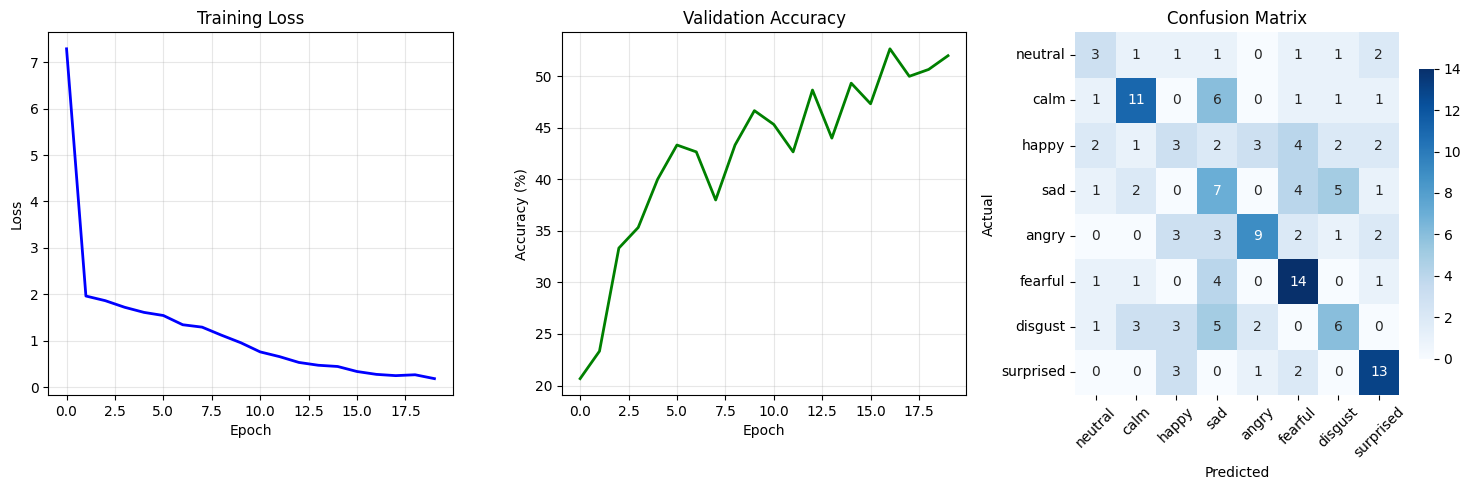

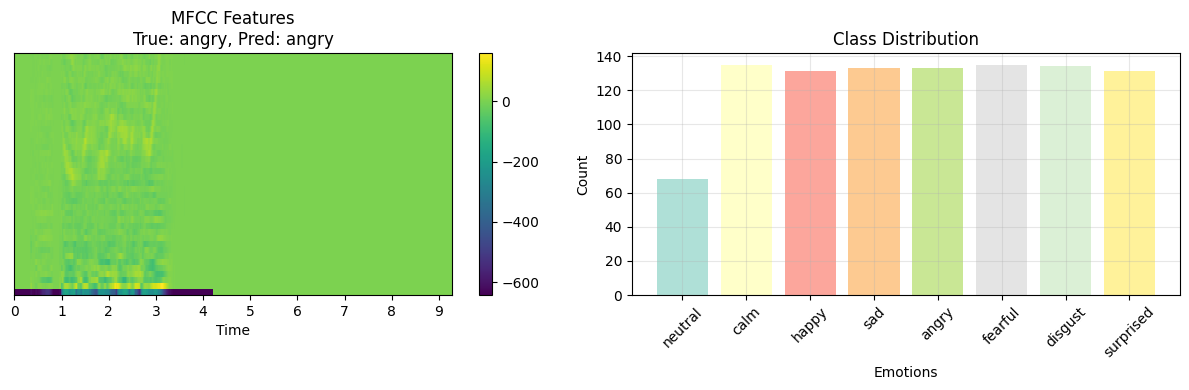

In [ ]:
# Cell 12: Visualization
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, 'g-', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names,
            cbar_kws={'shrink': 0.8})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Feature visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sample_idx = np.random.randint(0, len(X_test))
librosa.display.specshow(X_test[sample_idx], x_axis='time', cmap='viridis')
plt.colorbar()
true_emotion = emotion_names[targets[sample_idx]]
pred_emotion = emotion_names[predictions[sample_idx]]
plt.title(f'MFCC Features\nTrue: {true_emotion}, Pred: {pred_emotion}')

plt.subplot(1, 2, 2)
unique, counts = np.unique(y, return_counts=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique)))
plt.bar(unique, counts, color=colors, alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(unique, [emotion_names[i] for i in unique], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()